In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


Bad key "text.kerning_factor" on line 4 in
/home/batu/anaconda3/envs/rnn/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
PATH = "tmp/df_1minute_1yearago"
df = pd.read_feather(PATH)

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [4]:
df.count()

open time                       523436
open                            523436
high                            523436
low                             523436
close                           523436
volume                          523436
close time                      523436
quote asset volume              523436
number of trades                523436
taker buy based asset volume    523436
taker buy based quote volume    523436
ignore                          523436
dtype: int64

In [5]:
#import time
#for i in range(len(df)):
#    temp = df.iloc[i][6]
#    temp = temp[:-3]
#    temp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(temp)))
#    df.iloc[i][6] = temp    
#    print(temp)
#df.to_feather(PATH)

In [6]:
df.head().transpose()

,0,1,2,3,4
open time,2019-02-27 12:42:00,2019-02-27 12:43:00,2019-02-27 12:44:00,2019-02-27 12:45:00,2019-02-27 12:46:00
open,3822.81000000,3822.88000000,3821.86000000,3821.50000000,3822.77000000
high,3822.98000000,3822.90000000,3822.75000000,3823.08000000,3822.96000000
low,3822.02000000,3821.83000000,3821.00000000,3821.00000000,3819.33000000
close,3822.88000000,3821.84000000,3821.77000000,3823.00000000,3819.99000000
volume,10.45078000,23.87689200,14.93154600,12.13776500,17.13506200
close time,2019-02-27 12:42:59,2019-02-27 12:43:59,2019-02-27 12:44:59,2019-02-27 12:45:59,2019-02-27 12:46:59
quote asset volume,39947.81499464,91262.67234072,57062.86173317,46395.67586780,65462.03399792
number of trades,68,121,114,114,99
taker buy based asset volume,5.20190000,4.70267900,6.21381000,8.13017200,6.64419100


In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
TRAIN_SPLIT = 400000

In [9]:
tf.random.set_seed(13)

In [10]:
df_temp = df.drop(['open time','close time'], axis=1).astype('float')
df_temp.insert(loc= 0, column='open time', value=df['open time'])
df_temp.insert(loc= 6, column='close time', value=df['close time'])
df = df_temp

In [11]:
uni_data = df['close']
uni_data.index = df['close time']
uni_data.head()

close time
2019-02-27 12:42:59    3822.88
2019-02-27 12:43:59    3821.84
2019-02-27 12:44:59    3821.77
2019-02-27 12:45:59    3823.00
2019-02-27 12:46:59    3819.99
Name: close, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc32fffe4e0>],
      dtype=object)

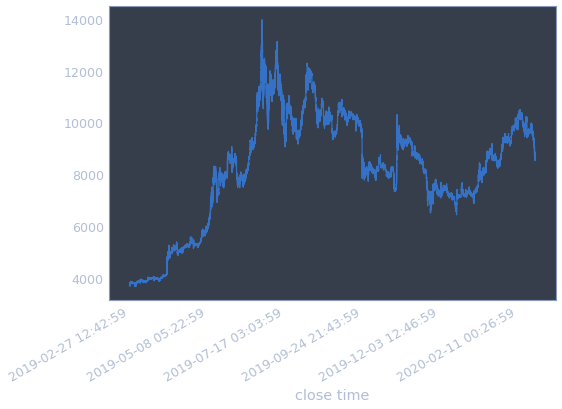

In [12]:
uni_data.plot(subplots=True)

In [13]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.80123616]
 [-1.8016712 ]
 [-1.80170048]
 [-1.80118597]
 [-1.80244506]
 [-1.80118178]
 [-1.80034936]
 [-1.80034936]
 [-1.80034518]
 [-1.80083878]
 [-1.80134492]
 [-1.80118597]
 [-1.80117342]
 [-1.80161264]
 [-1.80159591]
 [-1.80114414]
 [-1.800981  ]
 [-1.80127381]
 [-1.80076766]
 [-1.7999687 ]]

 Target temperature to predict
-1.8007007348228758


In [16]:
uni_data

array([-1.80123616, -1.8016712 , -1.80170048, ...,  0.26774918,
        0.27234634,  0.26877403])

In [17]:
def create_time_steps(length):
  return list(range(-length, 0))

In [18]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/batu/anaconda3/envs/rnn/lib/python3.6/site-packages/matplotlib/pyplot.py'>

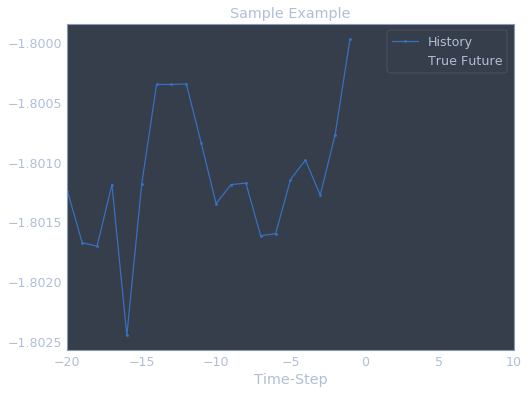

In [19]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


In [20]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/home/batu/anaconda3/envs/rnn/lib/python3.6/site-packages/matplotlib/pyplot.py'>

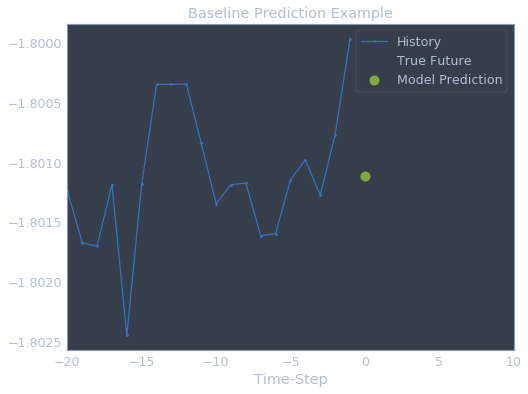

In [21]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [22]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [23]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [24]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [25]:
EVALUATION_INTERVAL = TRAIN_SPLIT / 1000
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 400.0 steps, validate for 50 steps
Epoch 1/10
400/400 [==============================] - 3s 7ms/step - loss: 0.3244 - val_loss: 0.0241
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0763 - val_loss: 0.0235
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0212
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0316 - val_loss: 0.3126
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0235 - val_loss: 0.0023
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0104 - val_loss: 0.0197
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 8/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0089 - val_loss: 0.0513
Epoch 9/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 10/10
400/400 [==============================] - 

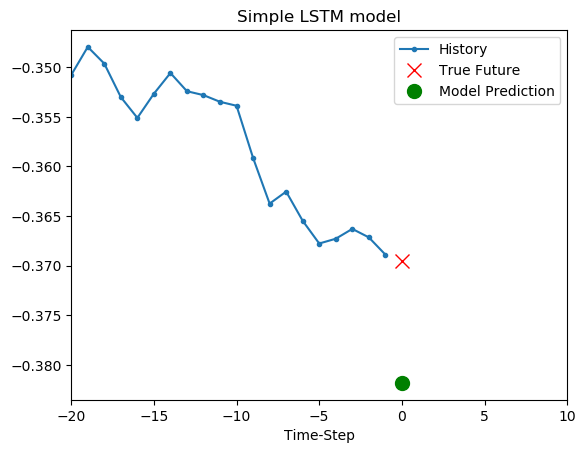

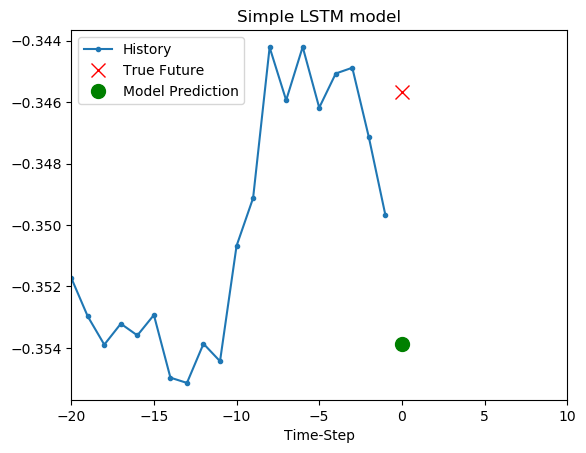

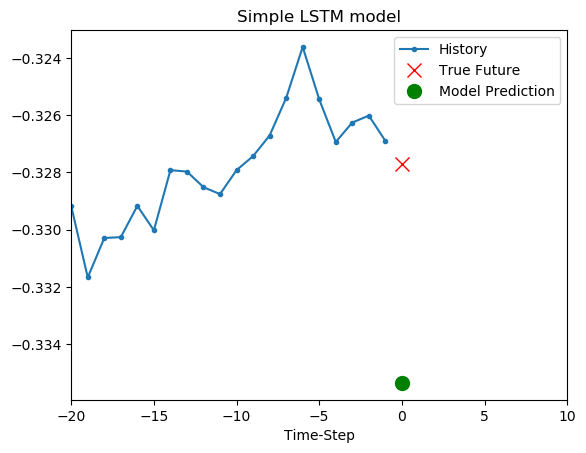

In [26]:
jtplot.reset()
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [27]:
features_considered = ['open','close','high','low','volume']

In [28]:
features = df[features_considered]
features.index = df['close time']
features.head()

,open,close,high,low,volume
close time,,,,,
2019-02-27 12:42:59,3822.81,3822.88,3822.98,3822.02,10.450780
2019-02-27 12:43:59,3822.88,3821.84,3822.90,3821.83,23.876892
2019-02-27 12:44:59,3821.86,3821.77,3822.75,3821.00,14.931546
2019-02-27 12:45:59,3821.50,3823.00,3823.08,3821.00,12.137765
2019-02-27 12:46:59,3822.77,3819.99,3822.96,3819.33,17.135062


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3289f6e10>,
      dtype=object)

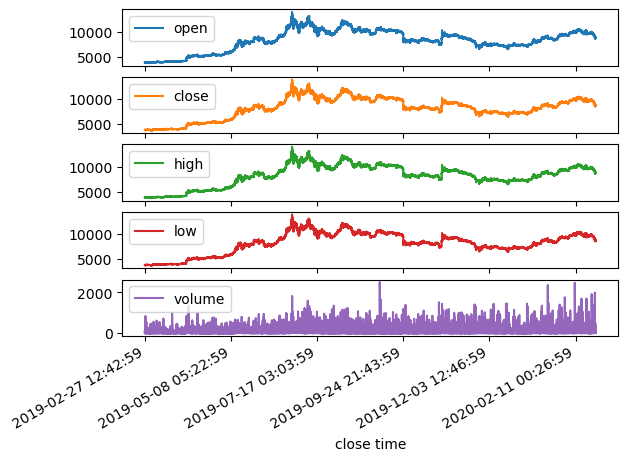

In [29]:
features.plot(subplots=True)

In [30]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [32]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [33]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 5)


In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [35]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [36]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [37]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 400.0 steps, validate for 50 steps
Epoch 1/10
400/400 [==============================] - 5s 12ms/step - loss: 0.0866 - val_loss: 0.0148
Epoch 2/10
400/400 [==============================] - 3s 8ms/step - loss: 0.0432 - val_loss: 0.0472
Epoch 3/10
400/400 [==============================] - 3s 8ms/step - loss: 0.0295 - val_loss: 0.0430
Epoch 4/10
400/400 [==============================] - 3s 8ms/step - loss: 0.0194 - val_loss: 0.0809
Epoch 5/10
400/400 [==============================] - 3s 8ms/step - loss: 0.0254 - val_loss: 0.0125
Epoch 6/10
400/400 [==============================] - 3s 8ms/step - loss: 0.0343 - val_loss: 0.0245
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 0.0224 - val_loss: 0.0246
Epoch 8/10
400/400 [==============================] - 3s 8ms/step - loss: 0.0185 - val_loss: 0.0503
Epoch 9/10
400/400 [==============================] - 3s 8ms/step - loss: 0.0230 - val_loss: 0.0117
Epoch 10/10
400/400 [==============================] -

In [38]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

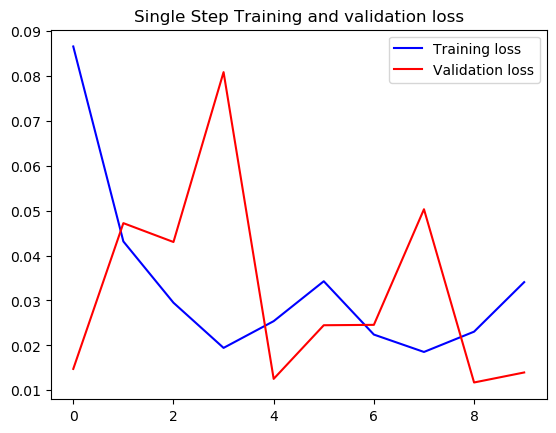

In [39]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

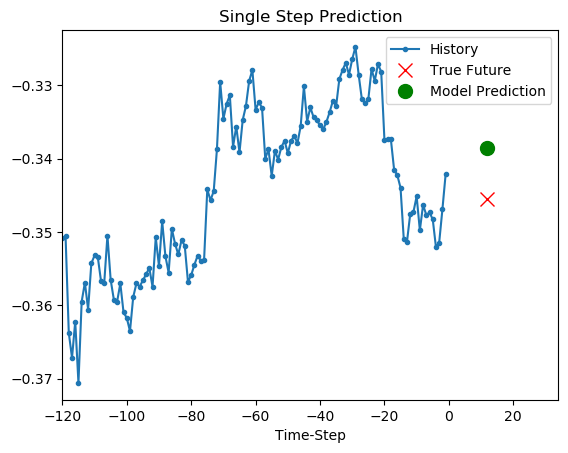

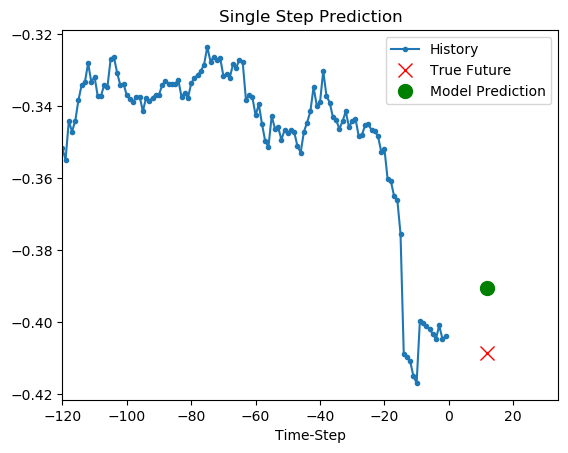

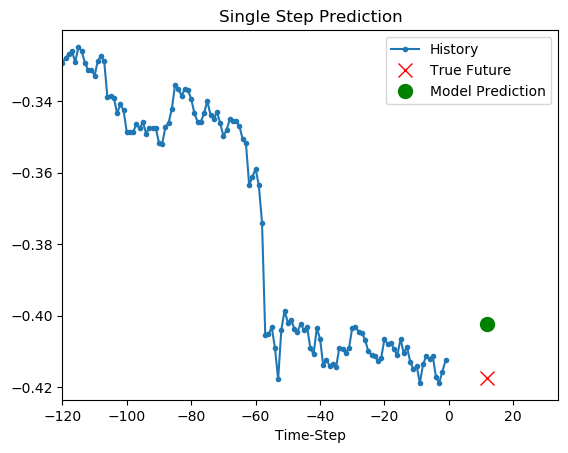

In [40]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [41]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [42]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [43]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

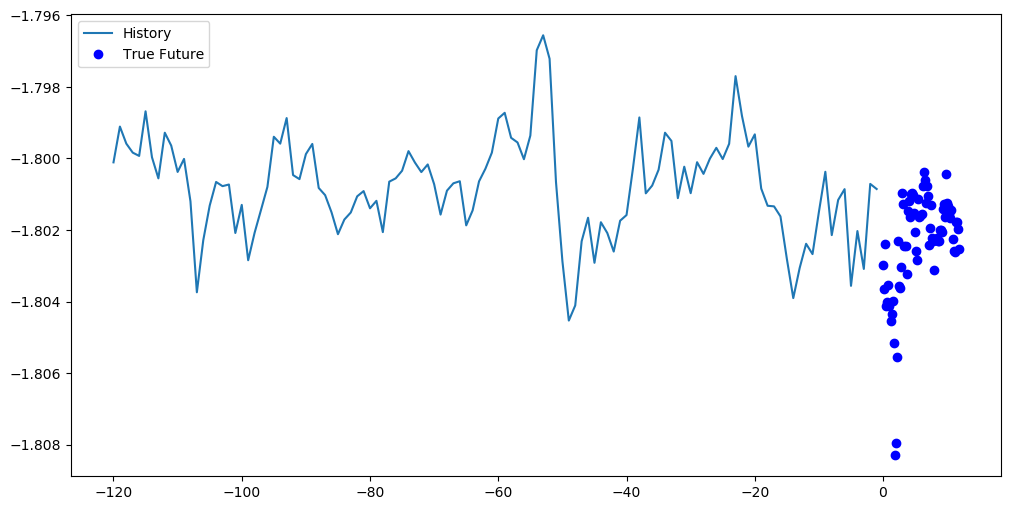

In [44]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [45]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [46]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 400.0 steps, validate for 50 steps
Epoch 1/10
400/400 [==============================] - 34s 84ms/step - loss: 0.2822 - val_loss: 0.0361
Epoch 2/10
400/400 [==============================] - 31s 79ms/step - loss: 138.7818 - val_loss: 0.0518
Epoch 3/10
400/400 [==============================] - 31s 79ms/step - loss: 0.0557 - val_loss: 0.0518
Epoch 4/10
400/400 [==============================] - 31s 79ms/step - loss: 0.0283 - val_loss: 0.1032
Epoch 5/10
400/400 [==============================] - 31s 78ms/step - loss: 0.0535 - val_loss: 0.0271
Epoch 6/10
400/400 [==============================] - 31s 78ms/step - loss: 0.0380 - val_loss: 0.0192
Epoch 7/10
400/400 [==============================] - 31s 78ms/step - loss: 0.0280 - val_loss: 0.0155
Epoch 8/10
400/400 [==============================] - 31s 79ms/step - loss: 0.0252 - val_loss: 0.0426
Epoch 9/10
400/400 [==============================] - 32s 79ms/step - loss: 0.0385 - val_loss: 0.0290
Epoch 10/10
400/400 [==============

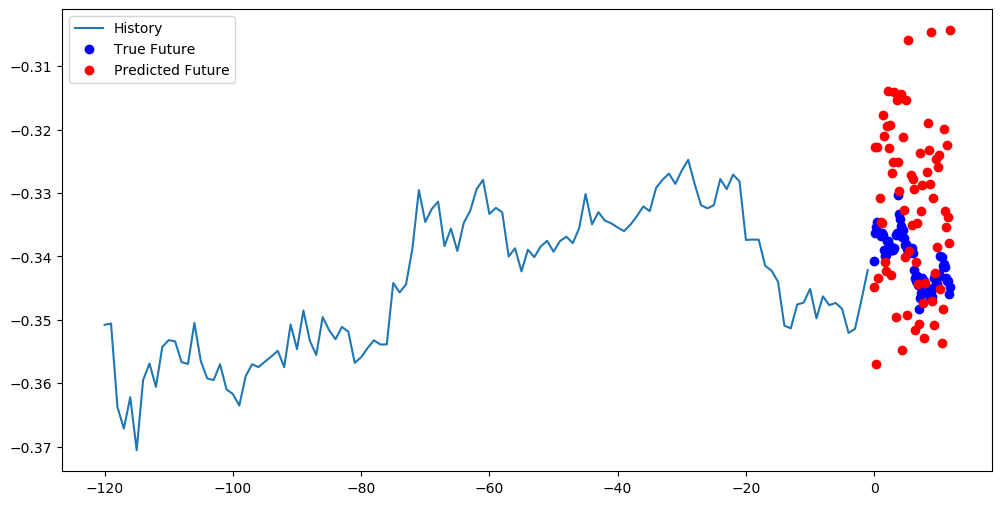

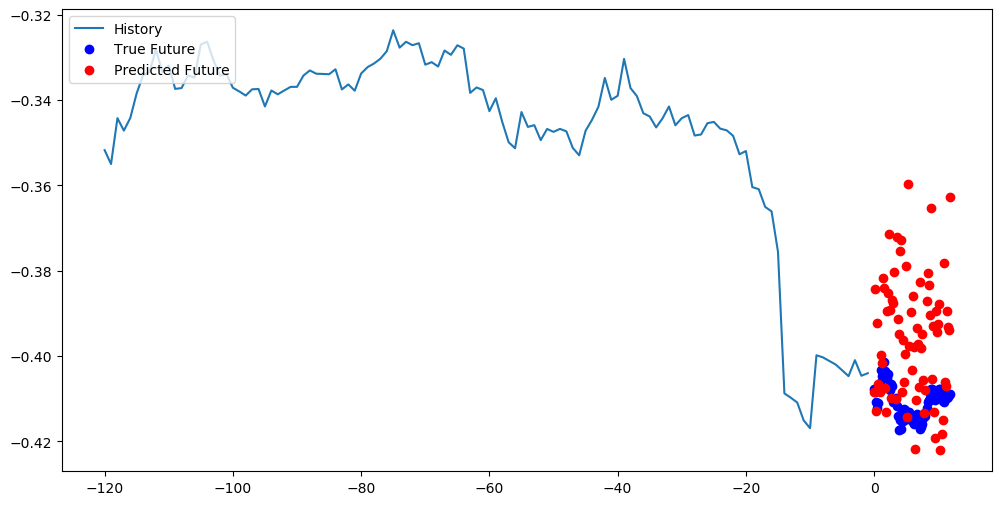

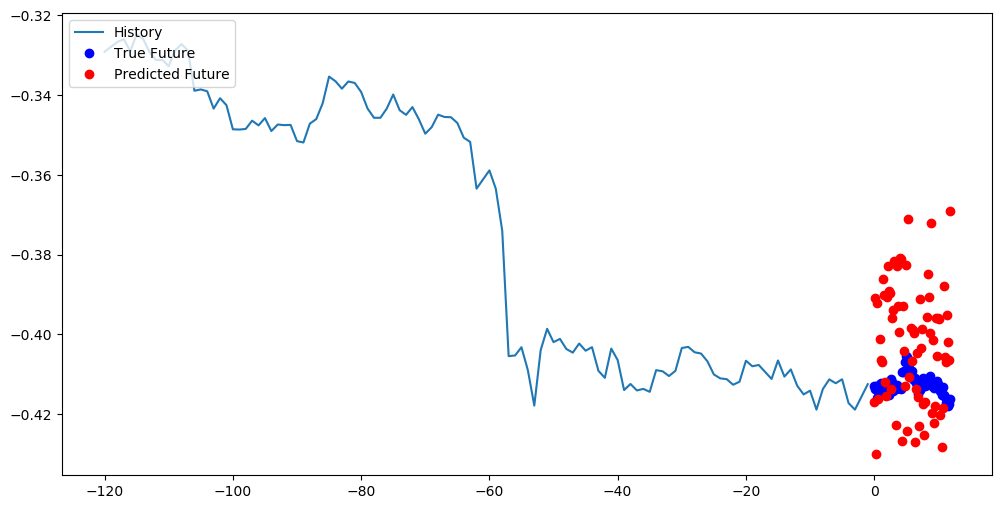

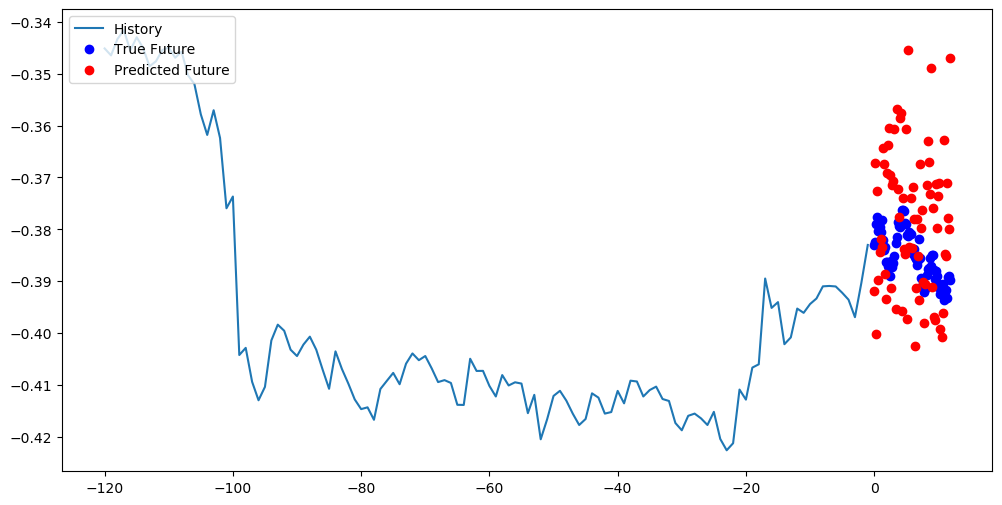

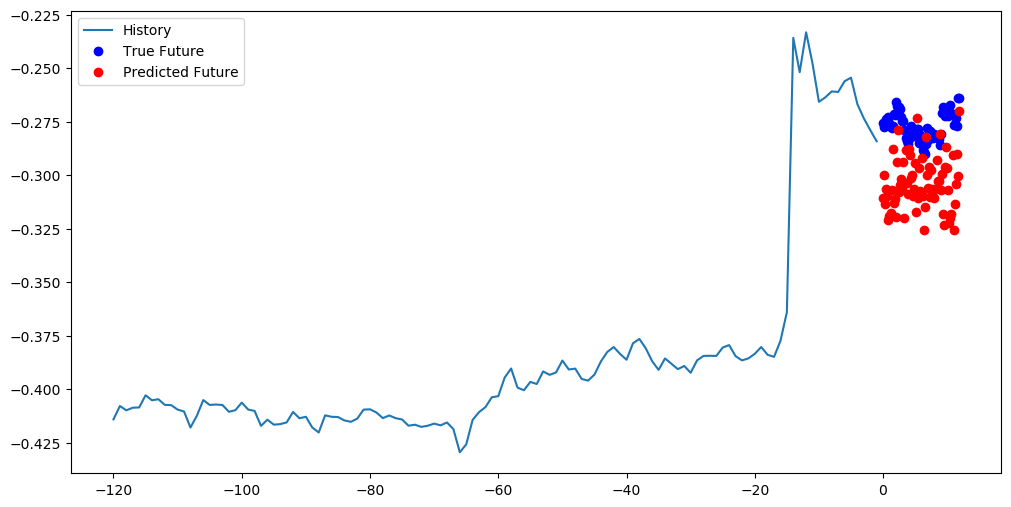

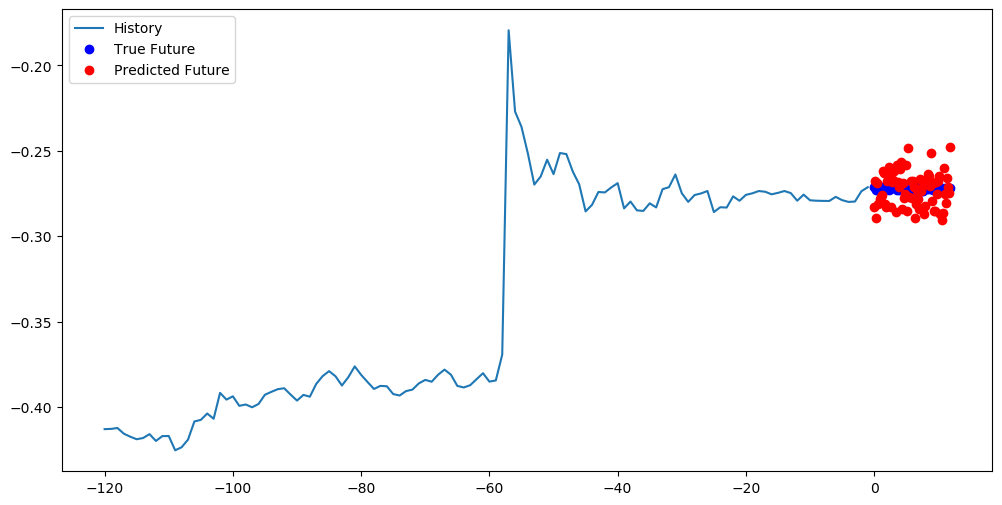

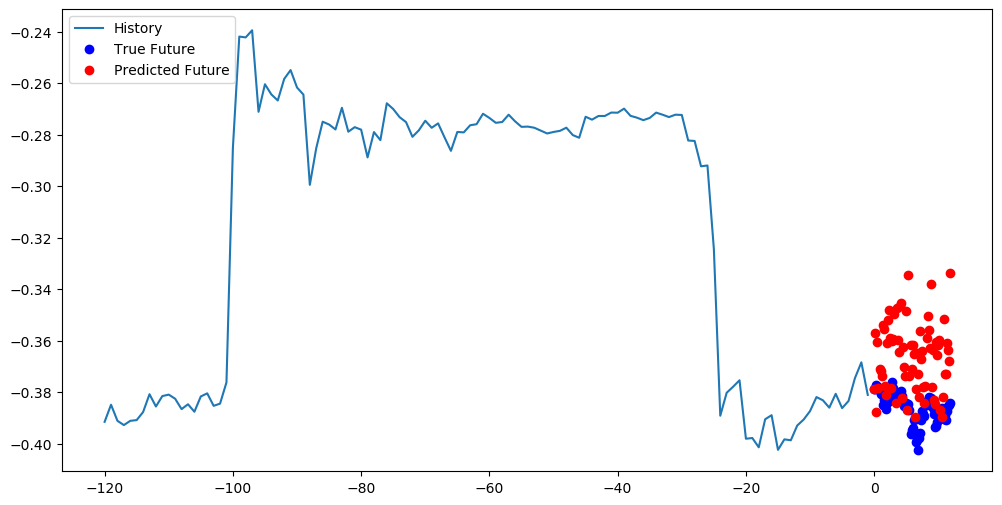

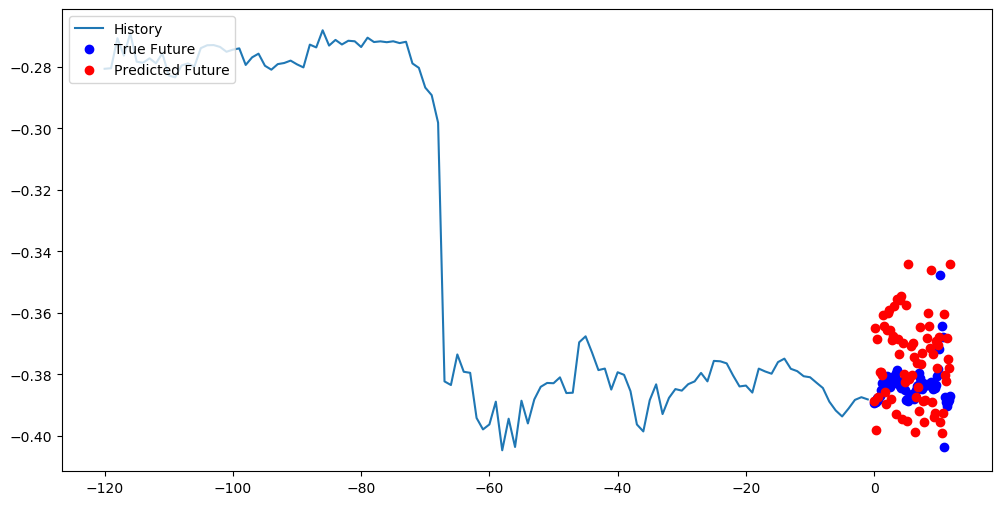

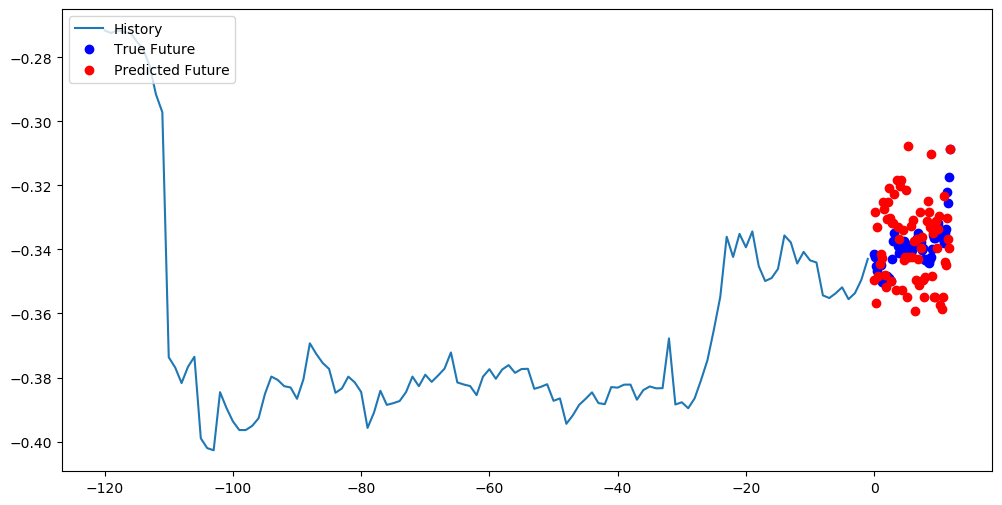

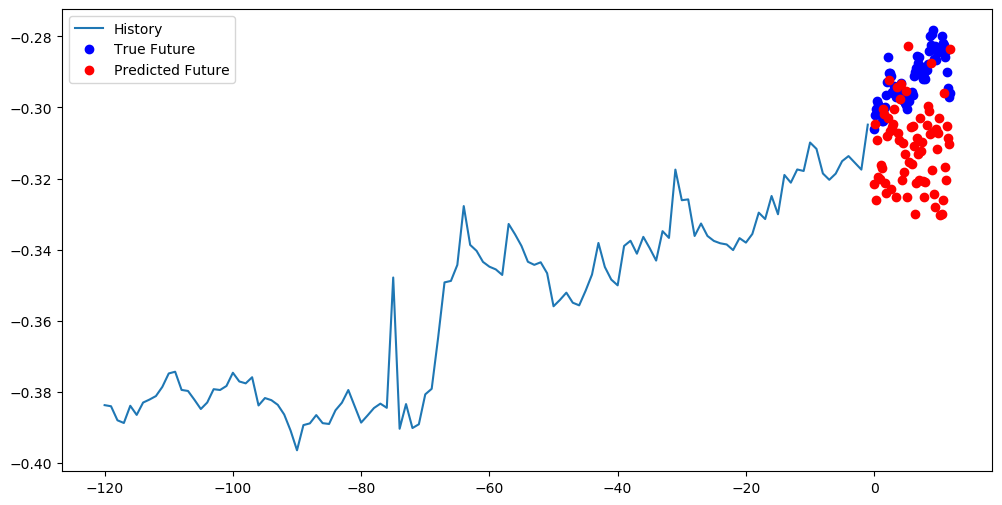

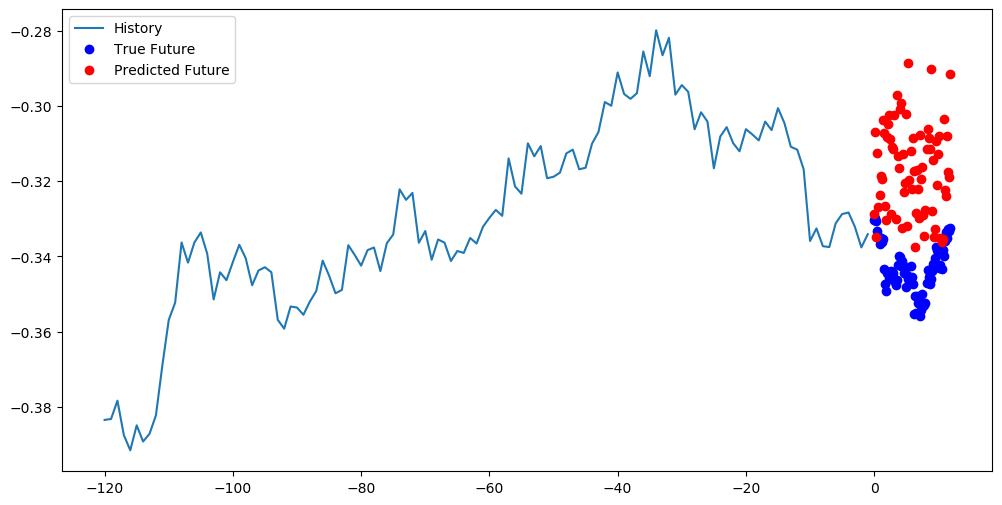

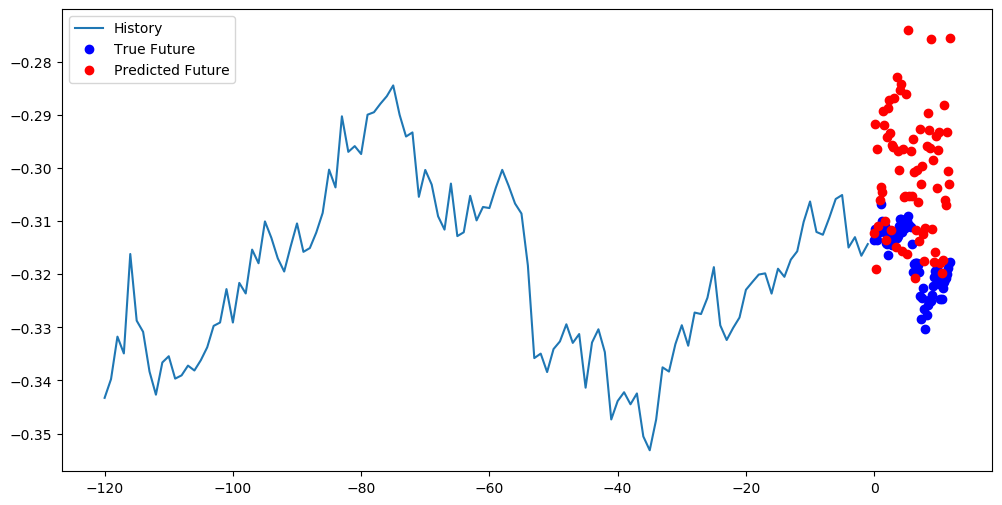

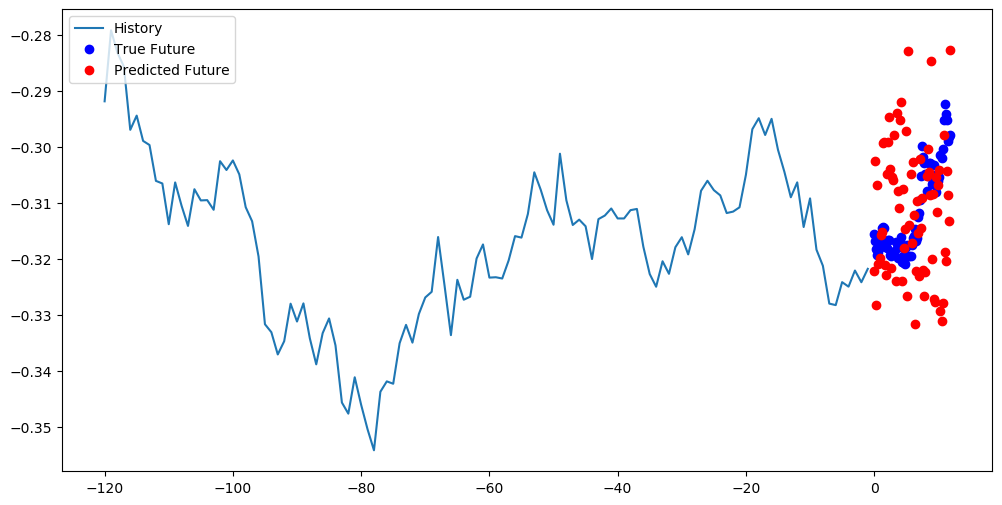

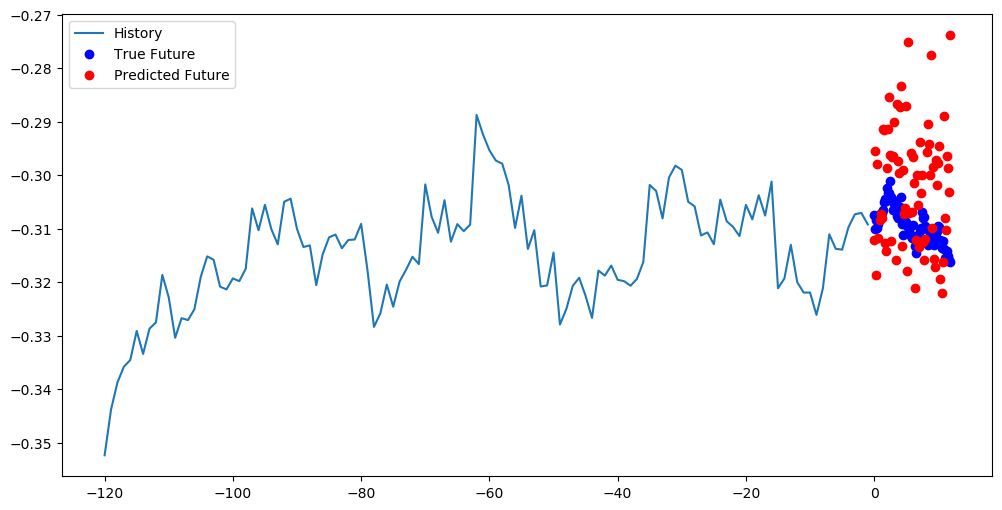

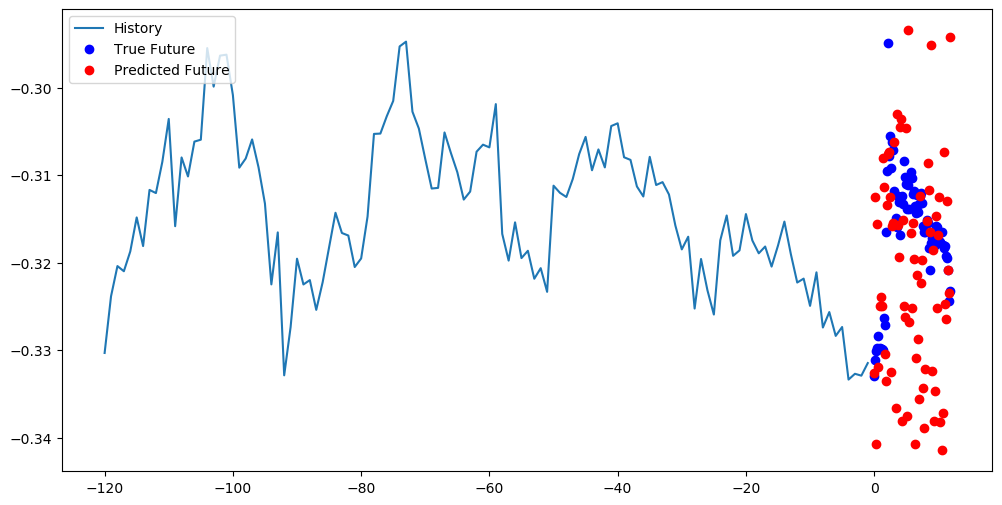

In [47]:
for x, y in val_data_multi.take(15):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])